In [5]:
import numpy as np

from matplotlib import pyplot as plt

import sys
sys.path.append('../scripts')
import flag_dimensionality_reduction as fdr
from RealFlag import RealFlag

import pandas as pd

import time

import os

import pymanopt


In [6]:
n = 4 #num rand vars
p = 30 #num samples (points in R^n)
fl_type = [1,2] #flag type
init = 'rand' #initialization



k = len(fl_type)  #num subspaces 
n_k = fl_type[-1] #dim of largest subspace


In [7]:
np.random.seed(420) #seed for data generation

X0 = np.random.rand(n,p)
column_means = np.mean(X0.T, axis=0)
Xcenter = X0.T - column_means
Xcenter = Xcenter.T
Xunit = np.vstack([x/np.linalg.norm(x) for x in X0.T]).T

In [8]:


class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

results = pd.DataFrame(columns = ['Optmization', 'PCA Type', 'Obj. Val.', 'Ostd', 'Time', 'Tstd'])

times_mine = []
times_st = []
times_fl = []
obj_val_mine = []
obj_val_st = []
obj_val_fl = []
for pc_type, pca_type in zip(['L1-RPCA', 'L1-WPCA', 'L1-DPCP'], ['rpca', 'wpca', 'dpcp']):
    if pca_type == 'dpcp':
        X = Xunit.copy()
    else:
        X = Xcenter.copy()

    fails = 0
    for init_seed in range(20):

        ############################################
        ############################################
        ############################################
        
        # Algorithm 1
        with HiddenPrints():
            start = time.time()
            mine, errs, cauchs = fdr.flag_robust_pca(X, flag_type = fl_type, pca_type =  pca_type, 
                                                   return_all = True, init = init, rand_seed = init_seed)
        times_mine.append((time.time() - start))

        ############################################
        ############################################

        # Pymanopt Stiefel optimization
        start = time.time()
        eyes = fdr.construct_eyes(fl_type)
        init_pt = fdr.initialize(X, pca_type, init, init_seed, n_k ,n)
        flag_type = [1,2]

        St = pymanopt.manifolds.stiefel.Stiefel(n,n_k)

        if pca_type in ['rpca', 'wpca']:
            @pymanopt.function.autograd(St) 
            def cost(point):
                f=0
                for i in range(k):
                    for j in range(p):
                        f -= (np.trace(X[:,[j]] @ X[:,[j]].T @ point @ eyes[i] @ point.T))**(1/2)
                return f

        elif pca_type == 'dpcp':
            @pymanopt.function.autograd(St) 
            def cost(point):
                f = 0
                for i in range(k):
                    for j in range(p):
                        foo = np.trace(X[:,[j]] @ X[:,[j]].T @ point @ eyes[i] @ point.T)
                        if foo < 0:
                            foo = 0
                        f += foo**(1/2)
                return f
        else:
            print(f'pca_type {pca_type} not recognized')    

        problem = pymanopt.Problem(St, cost)

        optimizer = pymanopt.optimizers.conjugate_gradient.ConjugateGradient(verbosity = 0, max_iterations = 600)

        result = optimizer.run(problem, initial_point = init_pt)

        theirs = result.point

        times_st.append(time.time() - start)

        obj_val_mine.append(fdr.objective_val(X, mine, eyes, pca_type))
        their_obj_val = fdr.objective_val(X, theirs, eyes, pca_type)
        if not np.isnan(their_obj_val):
            obj_val_st.append(their_obj_val)
        else:
            fails+= 1

    
        ############################################
        ############################################

        # Flag optimization
        start = time.time()
        eyes = fdr.construct_eyes(fl_type)
        init_pt = fdr.initialize(X, pca_type, init, init_seed, n_k ,n)
        flag_type = [1,2]
        real_flag_type = []
        real_flag_type.append(flag_type[0])
        for i in range(1,len(flag_type)):
            real_flag_type.append(flag_type[i] - flag_type[i-1])
        real_flag_type.append(n - flag_type[-1])
        real_flag_type.reverse()       

        # initialize a flag manifold object
        St = RealFlag(np.array(real_flag_type))

        if pca_type in ['rpca', 'wpca']:
            @pymanopt.function.autograd(St) 
            def cost(point):
                f=0
                for i in range(k):
                    for j in range(p):
                        f -= (np.trace(X[:,[j]] @ X[:,[j]].T @ point @ eyes[i] @ point.T))**(1/2)
                return f

        elif pca_type == 'dpcp':
            @pymanopt.function.autograd(St) 
            def cost(point):
                f = 0
                for i in range(k):
                    for j in range(p):
                        foo = np.trace(X[:,[j]] @ X[:,[j]].T @ point @ eyes[i] @ point.T)
                        if foo < 0:
                            foo = 0
                        f += foo**(1/2)
                return f
        else:
            print(f'pca_type {pca_type} not recognized')    

        problem = pymanopt.Problem(St, cost)

        optimizer = pymanopt.optimizers.trust_regions.TrustRegions(verbosity = 0, max_iterations = 600)

        result = optimizer.run(problem, initial_point = init_pt)

        theirs = result.point

        times_fl.append(time.time() - start)

        obj_val_mine.append(fdr.objective_val(X, mine, eyes, pca_type))
        their_obj_val = fdr.objective_val(X, theirs, eyes, pca_type)
        if not np.isnan(their_obj_val):
            obj_val_fl.append(their_obj_val)
        else:
            fails+= 1

        ############################################
        ############################################
        ############################################
            

    print(pca_type)
    print('----------------------')
    print('times:')
    print(f'{np.round(np.mean(times_mine),4)} +/- {np.round(np.std(times_mine),4)}')
    print(f'{np.round(np.mean(times_st),4)} +/- {np.round(np.std(times_st),4)}')
    print(f'{np.round(np.mean(times_fl),4)} +/- {np.round(np.std(times_fl),4)}')
    print('objective values:')
    print(f'{np.round(np.mean(obj_val_mine),4)} +/- {np.round(np.std(obj_val_mine),4)}')
    print(f'{np.round(np.mean(obj_val_st),4)} +/- {np.round(np.std(obj_val_st),4)}')
    print(f'{np.round(np.mean(obj_val_fl),4)} +/- {np.round(np.std(obj_val_fl),4)}')
    print(f'their failures: {fails}')
    print()
    print()
    row = pd.DataFrame(columns = results.columns,
                       data = [['Ours', pc_type, np.mean(obj_val_mine), np.std(obj_val_mine), np.mean(times_mine), np.std(times_mine)]])
    results = pd.concat([results, row])

    row = pd.DataFrame(columns = results.columns,
                       data = [['Stiefel-RCGD', pc_type, np.mean(obj_val_st), np.std(obj_val_st), np.mean(times_st), np.std(times_st)]])
    results = pd.concat([results, row])
    row = pd.DataFrame(columns = results.columns,
                       data = [['Flag-RTR', pc_type, np.mean(obj_val_fl), np.std(obj_val_fl), np.mean(times_fl), np.std(times_fl)]])
    results = pd.concat([results, row])


    results.to_csv('../Results/cgd_comparison.csv')

rpca
----------------------
times:
0.1048 +/- 0.0548
1.417 +/- 0.394
12.0405 +/- 3.1847
objective values:
16.2352 +/- 0.633
16.2419 +/- 0.7024
16.0491 +/- 0.6712
their failures: 0


wpca
----------------------
times:
0.2781 +/- 0.2153
1.1771 +/- 0.4203
13.0219 +/- 17.5641
objective values:
20.9077 +/- 4.7026
21.3443 +/- 5.1382
21.3125 +/- 5.2946
their failures: 0


dpcp
----------------------
times:
0.6787 +/- 0.8504
18.6615 +/- 125.975
87.9912 +/- 247.4805
objective values:
17.842 +/- 5.8118
18.1208 +/- 6.2178
18.2827 +/- 6.1233
their failures: 0




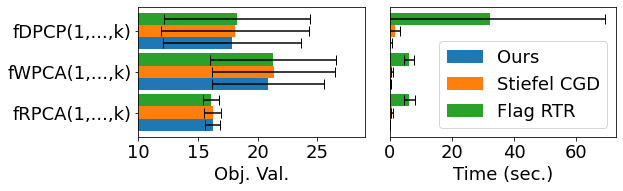

In [64]:
results = pd.read_csv('../Results/cgd_comparison_fl.csv', index_col = 0)

# Sample data
categories = ['fRPCA(1,...,k)', 'fWPCA(1,...,k)', 'fDPCP(1,...,k)']
plt.rcParams.update({'font.size': 18})

# Bar width
bar_width = 0.3

# X-axis positions for the categories
x_positions = np.arange(len(categories))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 3))  # 1 row, 2 columns

idx = (results['Optmization'] == 'Ours')
data1 = np.array(results[idx]['Obj. Val.'])
error1 = np.array(results[idx]['Ostd'])

idx = (results['Optmization'] == 'Stiefel-RCGD')
data2 = np.array(results[idx]['Obj. Val.'])
error2 = np.array(results[idx]['Ostd'])

idx = (results['Optmization'] == 'Flag-RTR')
data3 = np.array(results[idx]['Obj. Val.'])
error3 = np.array(results[idx]['Ostd'])


# Plotting the first set of bars with error bars in the first subplot
axs[0].barh(x_positions - bar_width, data1, bar_width, xerr=error1, capsize=5, color='tab:blue')
axs[0].barh(x_positions , data2, bar_width, xerr=error2, capsize=5, color='tab:orange')
axs[0].barh(x_positions + bar_width, data3, bar_width, xerr=error3, capsize=5, color='tab:green')
# axs[0].set_title('Subplot 1')
# axs[0].set_xlabel('')
axs[0].set_xlabel('Obj. Val.')
axs[0].set_yticks(x_positions)
axs[0].set_yticklabels(categories)
axs[0].set_xlim([10,29])
# axs[0].legend()

idx = (results['Optmization'] == 'Ours')
data1 = np.array(results[idx]['Time'])
error1 = np.array(results[idx]['Tstd'])

idx = (results['Optmization'] == 'Stiefel-RCGD')
data2 = np.array(results[idx]['Time'])
error2 = np.array(results[idx]['Tstd'])

idx = (results['Optmization'] == 'Flag-RTR')
data3 = np.array(results[idx]['Time'])
error3 = np.array(results[idx]['Tstd'])

# Plotting the second set of bars with error bars in the second subplot
axs[1].barh(x_positions - bar_width, data1, bar_width, xerr=error1, label='Ours', capsize=5, color='tab:blue')
axs[1].barh(x_positions , data2, bar_width, xerr=error2, label='Stiefel CGD', capsize=5, color='tab:orange')
axs[1].barh(x_positions + bar_width, data3, bar_width, xerr=error3, label='Flag RTR', capsize=5, color='tab:green')
# axs[1].set_title('Subplot 2')
# axs[1].set_xlabel('Categories')
axs[1].set_xlabel('Time (sec.)')
# axs[1].set_yticks(x_positions)
# axs[1].set_yticklabels(categories)
axs[1].set_xlim([0,73])
axs[1].legend()
axs[1].set_yticks([])

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.savefig('cgd_comparison_fl.pdf', bbox_inches='tight')
